In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import figures as f

#import os
#os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
#os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

import retrieval_base.auxiliary_functions as af
import pymultinest
import json
import copy

from tqdm import tqdm

import petitRADTRANS.nat_cst as nc

from scipy.ndimage import gaussian_filter1d

In [2]:
def read_results(prefix, n_params, m_set='K2166_A', w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_4/test_'
res = read_results(prefix=prefix_no_band, n_params=26)
_, _, PT_no_band, Chem_no_band, _, _, _, m_spec_no_band, d_spec, LogLike_no_band, Cov_no_band, bestfit_params_no_band = res
del res

prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_1/test_'
res = read_results(prefix=prefix_eq_band, n_params=28)
_, _, PT_eq_band, Chem_eq_band, _, _, _, m_spec_eq_band, d_spec, LogLike_eq_band, Cov_eq_band, bestfit_params_eq_band = res
del res

  analysing data from ./retrieval_outputs/no_bands_K_B_ret_4/test_.txt
  analysing data from ./retrieval_outputs/eq_band_K_B_ret_1/test_.txt


In [3]:
def get_pRT_atm(prefix, bestfit_params, Chem, PT, m_set='K2166_A', vsini_local=0, line_species=None):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{m_set}.pkl')

    # Compute global model spectrum
    params_global = copy.deepcopy(bestfit_params['params'][m_set])
    if prefix.endswith('no_bands_K_B_ret_4/test_'):
        params_global['lat_band'] = None
    pRT_atm.params = params_global

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    Rot = copy.copy(pRT_atm.Rot)

    # Compute local model spectrum
    params_local = copy.deepcopy(params_global)
    params_local['vsini'] = vsini_local
    params_local['lat_band'] = None
    params_local['lat_band_upper'] = 90
    params_local['epsilon_band'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    if line_species is not None:
        
        for key_i in mf_local.keys():
            # Set abundances of other species to 0
            if key_i != line_species:
                mf_local[key_i] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local, Rot

m_spec_global_no_band, m_spec_local_no_band, Rot_no_band = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band
    #prefix_no_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )
m_spec_global_eq_band, m_spec_local_eq_band, Rot_eq_band = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )

In [10]:
def get_CCF(
    d_spec, 
    m_spec_local, 
    m_spec_global, 
    LogLike, 
    Cov, 
    rv=np.arange(-200,200+1e-6,1), 
    filter_width=50, 
    subtract_global_from_template=True
    ):

    CCF = np.nan * np.ones(
        (len(rv), d_spec.n_orders, d_spec.n_dets)
        )
    
    d_wave = np.copy(d_spec.wave)
    d_res  = np.copy(d_spec.flux) - np.copy(LogLike.m_flux_phi)
    mask = d_spec.mask_isfinite

    # Apply high-pass filter to the residuals
    lp_d_res = np.nan*np.ones_like(d_res)
    lp_d_res[mask] = gaussian_filter1d(
        d_res[mask], sigma=filter_width, axis=-1, mode='nearest'
        )
    d_res -= lp_d_res

    for i, rv_i in enumerate(tqdm(rv)):

        for j in range(d_spec.n_orders):
            
            # Shift the model spectrum
            m_wave_local = np.copy(m_spec_local.wave_pRT_grid[j])
            m_wave_local *= (1 + rv_i/(nc.c*1e-5))

            m_flux_local = np.copy(m_spec_local.flux_pRT_grid[j])

            for k in range(d_spec.n_dets):

                # Don't consider the nans
                mask_jk = d_spec.mask_isfinite[j,k]

                if not mask_jk.any():
                    continue

                # Subtract the global model?
                if subtract_global_from_template:
                    m_res_local_jk = m_flux_local - m_spec_global.flux_pRT_grid[j]
                else:
                    m_res_local_jk = m_flux_local
                
                # Interpolate onto the data wavelength grid
                m_res_local_jk = np.interp(
                    d_wave[j,k], xp=m_wave_local, fp=m_res_local_jk
                    )
                m_res_local_jk *= LogLike.phi[j,k,0]

                # Apply high-pass filter to the model too
                lp_m_res_local_jk = np.nan*np.ones_like(m_res_local_jk)
                lp_m_res_local_jk[mask_jk] = gaussian_filter1d(
                    m_res_local_jk[mask_jk], sigma=filter_width, axis=-1, mode='nearest'
                    )
                m_res_local_jk -= lp_m_res_local_jk

                # Compute the cross-correlation coefficient
                CCF[i,j,k] = np.dot(
                    m_res_local_jk[mask_jk], LogLike.s2[j,k]**(-1) * Cov[j,k].solve(d_res[j,k,mask_jk])
                    )
    
    return CCF, rv

CCF_no_band, rv = get_CCF(
    d_spec, m_spec_local_no_band, m_spec_global_no_band, LogLike_no_band, Cov_no_band
    )
CCF_eq_band, rv = get_CCF(
    d_spec, m_spec_local_eq_band, m_spec_global_eq_band, LogLike_eq_band, Cov_eq_band
    )

  0%|          | 0/401 [00:00<?, ?it/s]

100%|██████████| 401/401 [00:04<00:00, 87.89it/s]


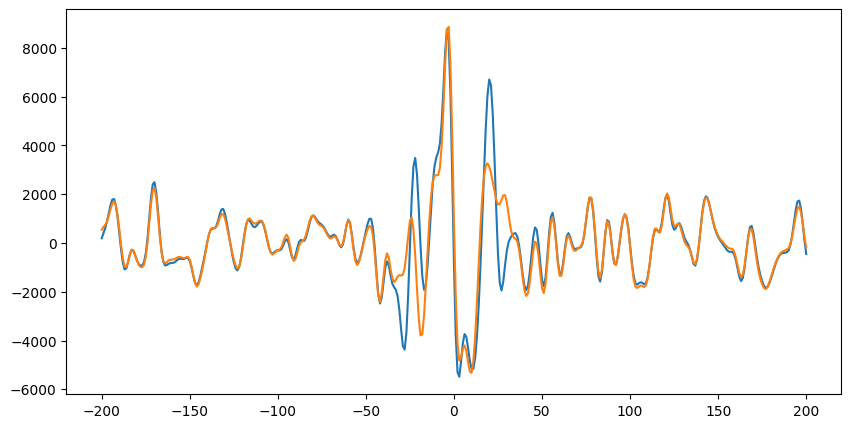

In [12]:
plt.figure(figsize=(10,5))
plt.plot(rv, CCF_no_band.sum(axis=(1,2)))
plt.plot(rv, CCF_eq_band.sum(axis=(1,2)))
plt.show()

In [4]:
'''
Rot_no_band.f_grid = Rot_no_band.get_f_grid(bestfit_params_no_band['params']['K2166_A'])
Rot_no_band.f_grid /= np.sum(Rot_no_band.f_grid * Rot_no_band.area_per_segment)
Rot_eq_band.f_grid = Rot_eq_band.get_f_grid(bestfit_params_eq_band['params']['K2166_A'])
Rot_eq_band.f_grid /= np.sum(Rot_eq_band.f_grid * Rot_eq_band.area_per_segment)

print(Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max())
print(Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max())

# Compute velocity-grid
vsini = bestfit_params_no_band['params']['K2166_A'].get('vsini', 0)
Rot_no_band.v_grid = vsini * Rot_no_band.r_grid * np.sin(Rot_no_band.theta_grid)

vsini = bestfit_params_eq_band['params']['K2166_A'].get('vsini', 0)
Rot_eq_band.v_grid = vsini * Rot_eq_band.r_grid * np.sin(Rot_eq_band.theta_grid)
'''

"\nRot_no_band.f_grid = Rot_no_band.get_f_grid(bestfit_params_no_band['params']['K2166_A'])\nRot_no_band.f_grid /= np.sum(Rot_no_band.f_grid * Rot_no_band.area_per_segment)\nRot_eq_band.f_grid = Rot_eq_band.get_f_grid(bestfit_params_eq_band['params']['K2166_A'])\nRot_eq_band.f_grid /= np.sum(Rot_eq_band.f_grid * Rot_eq_band.area_per_segment)\n\nprint(Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max())\nprint(Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max())\n\n# Compute velocity-grid\nvsini = bestfit_params_no_band['params']['K2166_A'].get('vsini', 0)\nRot_no_band.v_grid = vsini * Rot_no_band.r_grid * np.sin(Rot_no_band.theta_grid)\n\nvsini = bestfit_params_eq_band['params']['K2166_A'].get('vsini', 0)\nRot_eq_band.v_grid = vsini * Rot_eq_band.r_grid * np.sin(Rot_eq_band.theta_grid)\n"

In [5]:
print(bestfit_params_no_band['params']['K2166_A']['vsini'])
print(bestfit_params_eq_band['params']['K2166_A']['vsini'])

29.295173200397993
25.209022260524783


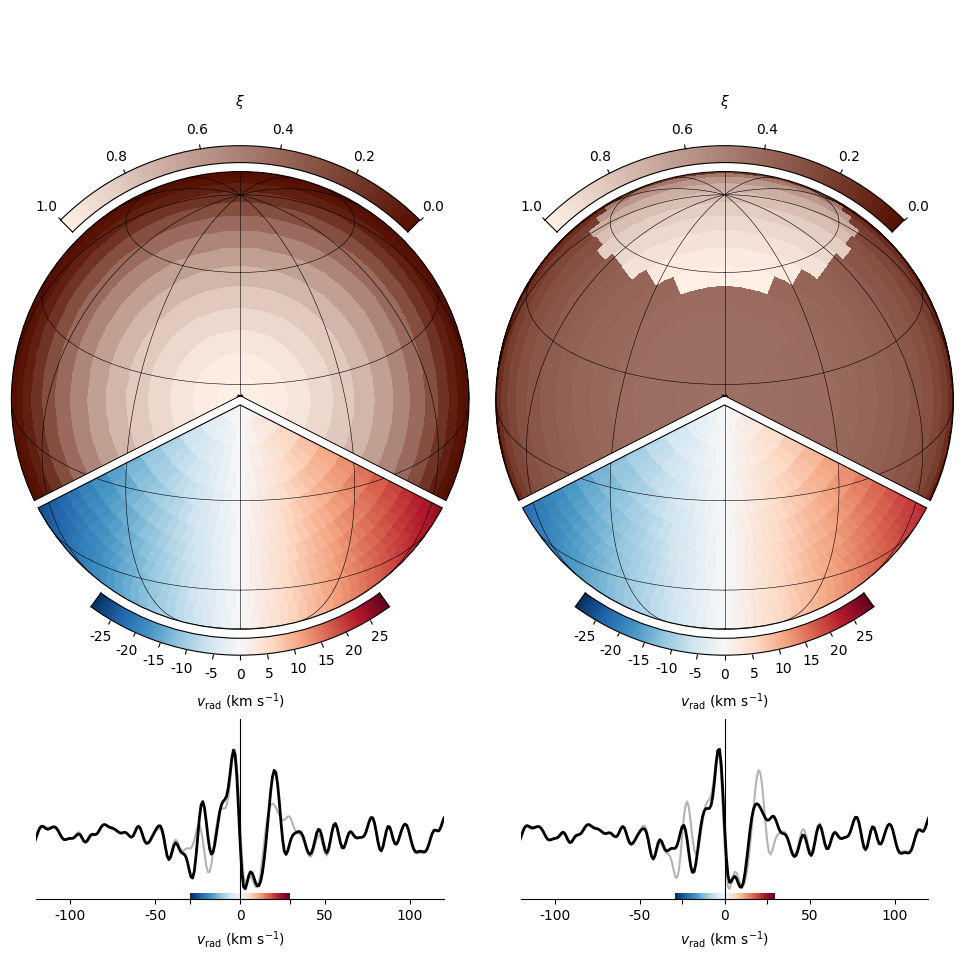

In [142]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['k','sienna'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#451400','#fedda7'])
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['#540f00','#fff0e6'])

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0, wspace=0.02)#, height_ratios=[0.1,0.8,0.1])

ax  = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

cax = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

vmin, vmax = Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max()
#vmin, vmax = 0, 1
f.plot_map(ax[0], 'f_grid', Rot_no_band, cmap=cmap, vmin=vmin, vmax=vmax)

#vmin, vmax = Rot_no_band.v_grid.min(), Rot_no_band.v_grid.max()
vmax = bestfit_params_no_band['params']['K2166_A']['vsini']
vmin = -vmax
f.plot_map(ax[1], 'v_grid', Rot_no_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)

vmin, vmax = Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max()
#vmin, vmax = 0, 1
f.plot_map(ax[2], 'f_grid', Rot_eq_band, cmap=cmap, vmin=vmin, vmax=vmax)

#vmin, vmax = Rot_eq_band.v_grid.min(), Rot_eq_band.v_grid.max()
#vmax = bestfit_params_eq_band['params']['K2166_A']['vsini']
vmax = bestfit_params_no_band['params']['K2166_A']['vsini']
vmin = -vmax
f.plot_map(ax[3], 'v_grid', Rot_eq_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)

spine_lw = 5
for i, (ax_i, Rot_i, theta_cen_i, theta_width_i) in enumerate(zip(
        ax, [Rot_no_band,Rot_no_band,Rot_eq_band,Rot_eq_band],
        #np.array([1,-1,1,-1])*np.pi/2, np.array([1.2,2-1.2,1.2,2-1.2])*np.pi
        np.array([1,-1,1,-1])*np.pi/2, np.array([1.3,2-1.3,1.3,2-1.3])*np.pi
        )):

    f.set_thetalim(ax_i, theta_cen_i, theta_width_i)
    f.set_axis(ax_i, Rot_i)

    wspace = 0
    if i >= 2:
        wspace = gs.wspace
    f.rescale_and_center(fig, ax_i, ax[0], x_offset=wspace)

f_grid_values = np.arange(0,1+1e-6,0.2).round(1)
vsini_values  = np.arange(-25,+25+1e-6,5,dtype=int)

f_grid_range = (0,1)
vsini_range  = (
    -bestfit_params_no_band['params']['K2166_A']['vsini'], 
    bestfit_params_no_band['params']['K2166_A']['vsini']
    )

f_grid_ann_kwargs = dict(xycoords='axes fraction', ha='center', va='bottom', xy=(0.5,1-0.28))
vsini_ann_kwargs  = dict(xycoords='axes fraction', ha='center', va='top', xy=(0.5,0.28))

for i, (cax_i, cmap_i) in enumerate(zip(cax, [cmap,'RdBu_r',cmap,'RdBu_r'])):

    theta_lim = [
        #(1/4*np.pi,3/4*np.pi),(-3/4*np.pi,-1/4*np.pi),
        #(1/4*np.pi,3/4*np.pi),(-3/4*np.pi,-1/4*np.pi)
        (1/4*np.pi,3/4*np.pi),(-np.pi/2-np.pi/5,-np.pi/2+np.pi/5),
        (1/4*np.pi,3/4*np.pi),(-np.pi/2-np.pi/5,-np.pi/2+np.pi/5)
        ][i]

    f.set_cb_axis(cax_i, theta_lim, cmap_i, r_origin=-14)

    ax_ref = [ax[0],ax[0],ax[2],ax[3]][i]

    f.rescale_and_center(fig, cax_i, ax_ref, coord_min=(0,-14), scale=1.11)

    ticks = [f_grid_values,vsini_values,f_grid_values,vsini_values][i]
    val_range = [f_grid_range,vsini_range,f_grid_range,vsini_range][i]
    label = [r'$\xi$',r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$',r'$\xi$',r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$'][i]
    ann_kwargs = [f_grid_ann_kwargs,vsini_ann_kwargs,f_grid_ann_kwargs,vsini_ann_kwargs][i]

    f.label_cb_axis(cax_i, ticks, val_range, label, ann_kwargs)


ax_CCF = []
for i, ax_ref in enumerate([ax[1],ax[3]]):
    l, b, w, h = ax_ref.get_position().bounds
    ax_CCF_dim = [l, b-0.3, w, 0.3]
    ax_CCF.append(fig.add_axes(ax_CCF_dim))

Z = np.linspace(0,1+1e-6,50).reshape(-1,1).T
gradient_kwargs = dict(
    #cmap=mpl.colors.LinearSegmentedColormap.from_list('',['0.8','w']), 
    cmap='RdBu_r', 
    vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
    )
ax_CCF[0].imshow(
    Z, extent=[
        -bestfit_params_no_band['params']['K2166_A']['vsini'], 
        bestfit_params_no_band['params']['K2166_A']['vsini'], 0, 0.03
        ], 
    transform=ax_CCF[0].get_xaxis_transform(), **gradient_kwargs
    )

#Z = np.linspace(0,1+1e-6,10).reshape(-1,1)
#gradient_kwargs = dict(
#    cmap=mpl.colors.LinearSegmentedColormap.from_list('',[(1,1,1,0.0),'w']), 
#    vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
#    )
#ax_CCF[0].imshow(
#    Z, extent=[
#        -bestfit_params_no_band['params']['K2166_A']['vsini'], 
#        bestfit_params_no_band['params']['K2166_A']['vsini'], 0, 0.07
#        ], 
#    transform=ax_CCF[0].get_xaxis_transform(), **gradient_kwargs
#    )

Z = np.linspace(0,1+1e-6,50).reshape(-1,1).T
gradient_kwargs = dict(
    #cmap=mpl.colors.LinearSegmentedColormap.from_list('',['0.8','w']), 
    cmap='RdBu_r', 
    vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
    )
ax_CCF[1].imshow(
    Z, extent=[
        -bestfit_params_no_band['params']['K2166_A']['vsini'], 
        bestfit_params_no_band['params']['K2166_A']['vsini'], 0, 0.03
        ], 
    transform=ax_CCF[1].get_xaxis_transform(), **gradient_kwargs
    )

#Z = np.linspace(0,1+1e-6,10).reshape(-1,1)
#gradient_kwargs = dict(
#    cmap=mpl.colors.LinearSegmentedColormap.from_list('',[(1,1,1,0.0),'w']), 
#    vmin=0, vmax=1, origin='lower', aspect='auto', zorder=-1, 
#    )
#ax_CCF[1].imshow(
#    Z, extent=[
#        -bestfit_params_no_band['params']['K2166_A']['vsini'], 
#        bestfit_params_no_band['params']['K2166_A']['vsini'], 0, 0.07
#        ], 
#    transform=ax_CCF[1].get_xaxis_transform(), **gradient_kwargs
#    )

ax_CCF[0].plot(rv, CCF_eq_band.sum(axis=(1,2)), c='0.7', lw=1.5)
ax_CCF[0].plot(rv, CCF_no_band.sum(axis=(1,2)), c='0.0', lw=2)

ax_CCF[1].plot(rv, CCF_no_band.sum(axis=(1,2)), c='0.7', lw=1.5)
ax_CCF[1].plot(rv, CCF_eq_band.sum(axis=(1,2)), c='0.0', lw=2)

vrad_range  = np.arange(-200,200+1e-6,50)
vrad_labels = np.concatenate((np.int64(vrad_range), np.array(['',''])))

vrad_range  = np.concatenate(
    (vrad_range, np.array([-1,1])*bestfit_params_no_band['params']['K2166_A']['vsini'])
    )
vrad_labels = vrad_labels[np.argsort(vrad_range)]
vrad_range  = vrad_range[np.argsort(vrad_range)]
ax_CCF[0].set(xticks=vrad_range, xticklabels=vrad_labels)

vrad_range  = np.arange(-200,200+1e-6,50)
vrad_labels = np.concatenate((np.int64(vrad_range), np.array(['',''])))

vrad_range  = np.concatenate(
    (vrad_range, np.array([-1,1])*bestfit_params_eq_band['params']['K2166_A']['vsini'])
    )
vrad_labels = vrad_labels[np.argsort(vrad_range)]
vrad_range  = vrad_range[np.argsort(vrad_range)]
ax_CCF[1].set(xticks=vrad_range, xticklabels=vrad_labels)

for ax_i in ax_CCF:
    ax_i.set(
        xlim=(-120,120), xlabel=r'$v_\mathrm{rad}\ \mathrm{(km\ s^{-1})}$', 
        ylim=(-6500,12000), yticks=[]
        )
    ax_i.spines[['right', 'top','left']].set_visible(False)
    ax_i.axvline(0, ymin=0, ymax=1, c='k', lw=0.8)

x2 = ax[2].get_position().bounds[0] + ax[2].get_position().bounds[2]
y2 = cax[2].get_position().bounds[1] + cax[2].get_position().bounds[3]
x1 = ax[0].get_position().bounds[0]
y1 = ax_CCF[0].get_position().bounds[1]

x1 -= 0.02; x2 += 0.02
y1 -= 0.1; y2 -= 0.1

x1 *= 12; x2 *= 12
y1 *= 6; y2 *= 6

bbox = mpl.transforms.Bbox([[x1,y1],[x2,y2]])
plt.savefig('./plots/banded_cloud_model.pdf', bbox_inches=bbox)

plt.show()


In [18]:
import numpy as np
from scipy.special import lambertw as W
from scipy.special import erfcinv

def Z_to_sigma(ln_Z1, ln_Z2):
    '''Convert log-evidences of two models to a sigma confidence level'''
    #np.set_printoptions(precision=50)
    B = np.exp(ln_Z1 - ln_Z2)
    p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
    sigma = np.sqrt(2)*erfcinv(p)
    #print "p-value = ", p
    #print "n_sigma = ", sigma
    print(ln_Z1-ln_Z2)
    return B, sigma

ln_Z_no_band = 0.109658653117324412E+07
ln_Z_eq_band = 0.109659565748377540E+07
Z_to_sigma(ln_Z_eq_band, ln_Z_no_band)

9.126310531282797


(9194.038200382802, 4.660183142105388)